In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
import re
# import seaborn as sns

## Matching Drugs GDSC

### Inspect Dataset

In [37]:
dataset1 = pd.read_csv("Cmax_viability_Matrix_GDSC1_COSMIC_IDs_cell_lines_with_exp_with_Hist_Site_Type.csv", sep="\t")
dataset2 = pd.read_csv("Cmax_viability_Matrix_GDSC2_COSMIC_IDs_cell_lines_with_exp_with_Hist_Site_Type.csv", sep="\t")

In [38]:
dataset1.head()

,CL_name,Type,Site,Histology,Erlotinib,Rapamycin,Sunitinib,Paclitaxel,Sorafenib,Imatinib,...,Palbociclib,Cetuximab,Rucaparib,Tamoxifen,Trametinib,Dabrafenib,Temozolomide,Fulvestrant,SN-38___1490,SN-38___1494
0,683665,myeloma,haematopoietic_and_lymphoid_tissue,lymphoid_neoplasm,0.819245,0.984035,0.989693,0.002520,0.635958,0.724846,...,0.969999,0.999042,0.689813,0.997752,0.996377,0.755212,0.809516,0.999443,0.112450,0.046155
1,684055,solid,bone,Ewings_sarcoma-peripheral_primitive_neuroectod...,0.875684,0.981489,0.990557,0.147540,0.285323,0.385621,...,0.762693,0.988388,0.411676,0.996402,0.989571,0.543138,0.853609,0.998427,0.013157,0.008486
2,684057,solid,bone,Ewings_sarcoma-peripheral_primitive_neuroectod...,0.907686,0.977205,0.987515,0.369700,0.601924,0.719877,...,0.929253,0.991851,0.494746,0.991770,0.992179,0.609826,0.863594,0.996158,0.105465,0.025397
3,684059,solid,bone,Ewings_sarcoma-peripheral_primitive_neuroectod...,0.808674,0.980255,0.989016,0.200863,0.554817,0.565992,...,0.878577,0.995194,0.351912,0.988711,0.988091,0.525560,0.880648,0.994103,0.005770,0.007203
4,684062,solid,bone,Ewings_sarcoma-peripheral_primitive_neuroectod...,0.728205,0.829504,0.983705,0.369992,0.695533,0.652762,...,0.913338,0.995112,0.339769,0.980733,0.963792,0.646123,0.887254,0.998629,0.809615,0.037608


In [14]:
dataset2.head()

,CL_name,Type,Site,Histology,Vinblastine,Cisplatin,Cytarabine,Docetaxel___1007,Docetaxel___1819,Gefitinib,...,Topotecan,Teniposide,Mitoxantrone,Dactinomycin___1811,Dactinomycin___1911,Nelarabine,Vincristine,Venetoclax,Osimertinib,Vinorelbine
0,749709,solid,breast,carcinoma,0.563645,0.892904,0.616832,0.023363,0.012612,0.968922,...,0.856028,0.044818,0.728835,0.802909,0.463751,0.859331,0.699594,0.662076,0.915726,0.078327
1,749710,solid,breast,carcinoma,0.929699,0.906993,0.589241,0.065036,0.248084,0.904237,...,0.932106,0.544189,0.593495,0.858984,0.541421,0.910781,0.977563,0.838520,0.852592,0.468999
2,749711,solid,breast,carcinoma,0.953077,0.863405,0.384572,0.007426,0.005277,0.979118,...,0.999070,0.363319,0.792085,0.849598,0.498843,0.940507,0.602270,0.672844,0.963700,0.011545
3,749712,solid,breast,carcinoma,0.277693,0.605286,0.480567,0.032876,NaN,0.954245,...,NaN,NaN,NaN,NaN,0.482235,NaN,NaN,0.722319,0.950604,0.148975
4,749713,solid,breast,carcinoma,NaN,0.429396,NaN,0.032322,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.737967,NaN,NaN


In [70]:
# SELECT DRUGS
drugs1 = list(np.unique(np.array([drug.split("_")[0] for drug in list(dataset1.columns)[4:]])))
drugs2= list(np.unique(np.array([drug.split("_")[0] for drug in list(dataset2.columns)[4:]])))
combined = drugs1 + drugs2
combined_drugs = list(np.unique(np.array(combined)))

In [75]:
print(sorted(combined_drugs))

['5-Fluorouracil', 'Afatinib', 'Alectinib', 'Axitinib', 'Belinostat', 'Bexarotene', 'Bicalutamide', 'Bleomycin', 'Bortezomib', 'Bosutinib', 'Cabozantinib', 'Carmustine', 'Cetuximab', 'Cisplatin', 'Crizotinib', 'Cyclophosphamide', 'Cytarabine', 'Dabrafenib', 'Dactinomycin', 'Dasatinib', 'Docetaxel', 'Doxorubicin', 'Epirubicin', 'Erlotinib', 'Etoposide', 'Fulvestrant', 'Gefitinib', 'Gemcitabine', 'Ibrutinib', 'Idelalisib', 'Imatinib', 'Irinotecan', 'Lapatinib', 'Lenalidomide', 'Methotrexate', 'Mitomycin-C', 'Mitoxantrone', 'Nelarabine', 'Nilotinib', 'Olaparib', 'Osimertinib', 'Oxaliplatin', 'Paclitaxel', 'Palbociclib', 'Panobinostat', 'Pazopanib', 'Pemetrexed', 'Ponatinib', 'Rapamycin', 'Rucaparib', 'Ruxolitinib', 'SN-38', 'Sorafenib', 'Sunitinib', 'Tamoxifen', 'Temozolomide', 'Temsirolimus', 'Teniposide', 'Topotecan', 'Trametinib', 'Tretinoin', 'Venetoclax', 'Vinblastine', 'Vincristine', 'Vinorelbine', 'Vismodegib', 'Vorinostat', 'Zoledronate']


In [61]:
dataset1.columns

Index(['CL_name', 'Type', 'Site', 'Histology', 'Erlotinib', 'Rapamycin',
       'Sunitinib', 'Paclitaxel', 'Sorafenib', 'Imatinib', 'Crizotinib',
       'Dasatinib', 'Bortezomib', 'Lapatinib', 'Doxorubicin___133',
       'Doxorubicin___1386', 'Etoposide', 'Gemcitabine___135',
       'Gemcitabine___1393', 'Mitomycin-C', 'Vinorelbine',
       'Bicalutamide___150', 'Bicalutamide___1502', 'Ponatinib',
       '5-Fluorouracil', 'Bexarotene', 'Bleomycin', 'Pazopanib', 'Ruxolitinib',
       'Idelalisib', 'Cabozantinib', 'Belinostat', 'Alectinib', 'Pemetrexed',
       'Panobinostat', 'Vinblastine', 'Cisplatin___1005', 'Cisplatin___1496',
       'Cytarabine', 'Docetaxel', 'Methotrexate', 'Tretinoin', 'Gefitinib',
       'Vorinostat', 'Nilotinib', 'Temsirolimus', 'Olaparib___1017',
       'Olaparib___1495', 'Bosutinib', 'Lenalidomide', 'Axitinib',
       'Afatinib___1032', 'Afatinib___1377', 'Vismodegib', 'Palbociclib',
       'Cetuximab', 'Rucaparib', 'Tamoxifen', 'Trametinib', 'Dabrafenib',
   

In [50]:
plate_numbers = 14
all_drugs = []

for plate_number in range(1, plate_numbers+1):
    print(f"Loading plate {plate_number}")
    plate_path = f"/cluster/work/bewi/data/tahoe100/h5ad/plate{plate_number}_filt_Vevo_Tahoe100M_WServicesFrom_ParseGigalab.h5ad"
    plate = sc.read_h5ad(plate_path, "r")
    plate_drugs = plate.obs["drug"].unique().tolist()
    all_drugs.extend(plate_drugs)

unique_drugs = set(all_drugs)

Loading plate 1
Loading plate 2
Loading plate 3
Loading plate 4
Loading plate 5
Loading plate 6
Loading plate 7
Loading plate 8
Loading plate 9
Loading plate 10
Loading plate 11
Loading plate 12
Loading plate 13
Loading plate 14


In [85]:
print(f"Number of drugs: {len(unique_drugs)}")
print(f"Drugs: {sorted(unique_drugs)}")

Number of drugs: 380
Drugs: ['(R)-Verapamil (hydrochloride)', '(S)-Crizotinib', '18β-Glycyrrhetinic acid', '4EGI-1', '5-Azacytidine', '5-Fluorouracil', '8-Hydroxyquinoline', '9-ING-41', 'APTO-253', 'AT7519', 'AZD-7648', 'AZD-8055', 'AZD1390', 'AZD2858', 'Abemaciclib', 'Abiraterone acetate', 'Acetazolamide', 'Acetohexamide', 'Adagrasib', 'Adenine', 'Adenosine', 'Afatinib', 'Aliskiren', 'Allantoin', 'Allopurinol', 'Almonertinib (hydrochloride)', 'Almonertinib (mesylate)', 'Alpelisib', 'Altretamine', 'Amsacrine', 'Anastrozole', 'Anethole trithione', 'Apalutamide', 'Aprepitant', 'Arbutin', 'Artemether', 'Artesunate', 'Asciminib', 'Aspirin', 'Ataluren', 'Atazanavir (sulfate)', 'Auranofin', 'Azithromycin (hydrate)', 'BAY1125976', 'BI-3406', 'BI-78D3', 'Baicalin', 'Balsalazide (sodium hydrate)', 'Belinostat', 'Belumosudil', 'Belumosudil (mesylate)', 'Belzutifan', 'Bendamustine', 'Benproperine (phosphate)', 'Bentamapimod', 'Benztropine (mesylate)', 'Berbamine', 'Berbamine (dihydrochloride)', '

In [88]:
# See which GDSC drugs coincide with Tahoe
matching_drugs = []

for gdsc_drug in combined_drugs:
    for tahoe_drug in unique_drugs:
        if gdsc_drug in tahoe_drug:
            matching_drugs.append(tahoe_drug)

len(matching_drugs)

41

Drugs to inspect:

In [90]:
print('[' + ', '.join(f'"{d}"' for d in sorted(matching_drugs)) + ']')

["(S)-Crizotinib", "5-Fluorouracil", "Afatinib", "Belinostat", "Bexarotene", "Bicalutamide", "Bortezomib", "Cabozantinib (S-malate)", "Crizotinib (hydrochloride)", "Cytarabine", "Cytarabine (hydrochloride)", "Dabrafenib", "Docetaxel", "Docetaxel (Trihydrate)", "Doxorubicin (hydrochloride)", "Epirubicin (hydrochloride)", "Erlotinib", "Fulvestrant", "Gefitinib", "Gemcitabine", "Irinotecan", "Irinotecan (hydrochloride)", "Lapatinib ditosylate", "Lenalidomide (hemihydrate)", "Methotrexate", "Mitoxantrone (dihydrochloride)", "Osimertinib (mesylate)", "Oxaliplatin", "Paclitaxel", "Panobinostat", "Pemetrexed", "Ponatinib", "Rapamycin", "Rucaparib (phosphate)", "Sunitinib", "Temsirolimus", "Topotecan (hydrochloride)", "Trametinib", "Trametinib (DMSO_TF solvate)", "Vinblastine (sulfate)", "Vismodegib"]


Check cell lines:

In [67]:
cell_lines = ['MIA PaCa-2', 'HS-578T', 'HOP62', 'A-172', 'LOX-IMVI', 'RPMI-7951', 'H4', 'A549', 'A498', 'BT-474', 'CHP-212', 'NCI-H2030', 'LoVo', 'LS 180', 'SNU-1', 'HCT15', 'Hs 766T', 'NCI-H1573', 'SNU-423', 'AsPC-1', 'NCI-H460', 'NCI-H23', 'CFPAC-1', 'HT-29', 'COLO 205', 'SW1417', 'NCI-H1792', 'RKO', 'J82', 'C-33 A', 'C32', 'NCI-H2347', 'KATO III', 'A-427', 'SK-MEL-2', 'SHP-77', 'NCI-H661', 'NCI-H2122', 'NCI-H596']
for line in cell_lines:
    if line in adata.obs["cell_name"].unique():
        print(line)

MIA PaCa-2
HS-578T
HOP62
A-172
LOX-IMVI
RPMI-7951
H4
A549
A498
BT-474
CHP-212
NCI-H2030
LoVo
LS 180
SNU-1
HCT15
Hs 766T
NCI-H1573
SNU-423
AsPC-1
NCI-H460
NCI-H23
CFPAC-1
HT-29
COLO 205
SW1417
NCI-H1792
RKO
J82
C-33 A
C32
NCI-H2347
KATO III
A-427
SK-MEL-2
SHP-77
NCI-H661
NCI-H2122
NCI-H596


In [71]:
print('[' + ', '.join(f'"{d}"' for d in cell_lines) + ']')

["MIA PaCa-2", "HS-578T", "HOP62", "A-172", "LOX-IMVI", "RPMI-7951", "H4", "A549", "A498", "BT-474", "CHP-212", "NCI-H2030", "LoVo", "LS 180", "SNU-1", "HCT15", "Hs 766T", "NCI-H1573", "SNU-423", "AsPC-1", "NCI-H460", "NCI-H23", "CFPAC-1", "HT-29", "COLO 205", "SW1417", "NCI-H1792", "RKO", "J82", "C-33 A", "C32", "NCI-H2347", "KATO III", "A-427", "SK-MEL-2", "SHP-77", "NCI-H661", "NCI-H2122", "NCI-H596"]


### Inspect Generated Adata

In [13]:
adata_path= "/cluster/scratch/rquiles/GSDC_1_2.h5ad"
adata = sc.read_h5ad(adata_path)

In [14]:
adata.obs

,sample,gene_count,tscp_count,mread_count,drugname_drugconc,Agg_Treatment,cell_line,sublibrary,BARCODE,pcnt_mito,S_score,G2M_score,phase,pass_filter,cell_name,plate,control,dose,split
BARCODE_SUB_LIB_ID,,,,,,,,,,,,,,,,,,,
56_080_129-lib_2452,smp_2606,1195,1743,2034,"[('Bexarotene', 5.0, 'uM')]",Bexarotene,CVCL_0023,lib_2452,56_080_129,0.062536,-0.076190,-0.085940,G1,full,A549,plate12,0,5.00,test
92_097_189-lib_2480,smp_2642,2358,4043,4617,"[('Panobinostat', 5.0, 'uM')]",Panobinostat,CVCL_0332,lib_2480,92_097_189,0.077170,-0.167806,-0.104619,G1,full,HS-578T,plate12,0,5.00,train
36_076_077-lib_1030,smp_1722,2644,5071,6010,"[('Afatinib', 5.0, 'uM')]",Afatinib,CVCL_0023,lib_1030,36_076_077,0.073753,-0.214286,-0.109220,G1,full,A549,plate3,0,5.00,test
95_111_050-lib_2476,smp_2645,587,788,924,"[('DMSO_TF', 0.0, 'uM')]",DMSO_TF,CVCL_1094,lib_2476,95_111_050,0.104061,-0.047961,-0.033309,G1,full,C-33 A,plate12,1,0.00,test
61_165_128-lib_1008,smp_1651,1057,1599,1969,"[('Bortezomib', 0.5, 'uM')]",Bortezomib,CVCL_1717,lib_1008,61_165_128,0.068793,-0.051587,-0.100386,G1,full,SW1417,plate2,0,0.50,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78_147_021-lib_1844,smp_2532,1864,2949,3447,"[('Methotrexate', 0.5, 'uM')]",Methotrexate,CVCL_0366,lib_1844,78_147_021,0.032893,-0.003968,-0.099634,G1,full,SNU-423,plate11,0,0.50,train
39_072_049-lib_2521,smp_1821,1273,2028,2386,"[('Rapamycin', 0.05, 'uM')]",Rapamycin,CVCL_1285,lib_2521,39_072_049,0.008383,-0.129187,-0.128571,G1,full,HOP62,plate4,0,0.05,train
83_189_169-lib_1928,smp_2633,2249,4450,5135,"[('Vismodegib', 5.0, 'uM')]",Vismodegib,CVCL_0152,lib_1928,83_189_169,0.073483,-0.143882,-0.177885,G1,full,AsPC-1,plate12,0,5.00,train


In [12]:
# Do train/test split and save to adata.obs
from sklearn.model_selection import train_test_split
import anndata as ad

# Load only obs (it’s stored in RAM; the expression matrix is not)

# Do your split
test_ratio = 0.2
random_state = 42
adata.obs["split"] = "train"
idx_train, idx_test = train_test_split(
    adata.obs.index, test_size=test_ratio, random_state=random_state
)
adata.obs["split"].loc[idx_train] = "train"
adata.obs.loc[idx_test, "split"] = "test"

# Changes are saved automatically because backed='r+'
adata.write(adata_path)

/scratch/tmp.47265523.rquiles/ipykernel_831344/2355923854.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["split"].loc[idx_train] = "train"


## Inspect plates

In [3]:
plate_number = 1
plate_path = f"/cluster/work/bewi/data/tahoe100/h5ad/plate{plate_number}_filt_Vevo_Tahoe100M_WServicesFrom_ParseGigalab.h5ad"
adata1 = sc.read_h5ad(plate_path, "r")

In [4]:
adata1.obs

,sample,gene_count,tscp_count,mread_count,drugname_drugconc,drug,cell_line,sublibrary,BARCODE,pcnt_mito,S_score,G2M_score,phase,pass_filter,cell_name,plate
BARCODE_SUB_LIB_ID,,,,,,,,,,,,,,,,
01_001_025-lib_841,smp_1495,1676,2441,2892,"[('Infigratinib', 0.05, 'uM')]",Infigratinib,CVCL_0131,lib_841,01_001_025,0.025399,-0.066667,-0.095055,G1,full,A-172,plate1
01_001_026-lib_841,smp_1495,1657,2454,2925,"[('Infigratinib', 0.05, 'uM')]",Infigratinib,CVCL_0480,lib_841,01_001_026,0.042787,0.128571,0.650549,G2M,full,PANC-1,plate1
01_001_048-lib_841,smp_1495,1749,2521,2963,"[('Infigratinib', 0.05, 'uM')]",Infigratinib,CVCL_0293,lib_841,01_001_048,0.056724,0.242857,0.308791,G2M,full,HEC-1-A,plate1
01_001_076-lib_841,smp_1495,834,1038,1258,"[('Infigratinib', 0.05, 'uM')]",Infigratinib,CVCL_0397,lib_841,01_001_076,0.066474,0.009524,0.245788,G2M,full,LS 180,plate1
01_001_088-lib_841,smp_1495,1275,1710,2006,"[('Infigratinib', 0.05, 'uM')]",Infigratinib,CVCL_1097,lib_841,01_001_088,0.028655,-0.100000,-0.085348,G1,full,C32,plate1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96_190_045-lib_912,smp_1590,1335,1900,2252,"[('DMSO_TF', 0.0, 'uM')]",DMSO_TF,CVCL_0546,lib_912,96_190_045,0.058421,-0.028936,0.615753,G2M,full,SW480,plate1
96_190_086-lib_912,smp_1590,2676,6496,7730,"[('DMSO_TF', 0.0, 'uM')]",DMSO_TF,CVCL_0152,lib_912,96_190_086,0.163639,-0.215881,-0.219544,G1,full,AsPC-1,plate1
96_191_055-lib_912,smp_1590,832,1254,1475,"[('DMSO_TF', 0.0, 'uM')]",DMSO_TF,CVCL_0152,lib_912,96_191_055,0.066188,-0.095694,-0.076463,G1,full,AsPC-1,plate1


In [96]:
metadata_path = "/cluster/work/bewi/members/rquiles/experiments/datasets/obs_metadata.parquet"
metadata = pd.read_parquet(metadata_path)

In [99]:
metadata_drugs = metadata["drug"].unique().tolist()

In [100]:
for drug in matching_drugs:
    if drug not in metadata_drugs:
        print(drug)
# ALL DRUGS ARE WRITTEN EQUALLY IN THE METADATA

## GDSC Dataset

In [3]:
data_path = "/cluster/scratch/rquiles/GSDC_1_2.h5ad"
adata = sc.read_h5ad(data_path, "r")

In [5]:
adata.obs

,sample,gene_count,tscp_count,mread_count,drugname_drugconc,Agg_Treatment,cell_line,sublibrary,BARCODE,pcnt_mito,S_score,G2M_score,phase,pass_filter,cell_name,plate,control,dose,split
BARCODE_SUB_LIB_ID,,,,,,,,,,,,,,,,,,,
56_080_129-lib_2452,smp_2606,1195,1743,2034,"[('Bexarotene', 5.0, 'uM')]",Bexarotene,CVCL_0023,lib_2452,56_080_129,0.062536,-0.076190,-0.085940,G1,full,A549,plate12,0,5.00,test
92_097_189-lib_2480,smp_2642,2358,4043,4617,"[('Panobinostat', 5.0, 'uM')]",Panobinostat,CVCL_0332,lib_2480,92_097_189,0.077170,-0.167806,-0.104619,G1,full,HS-578T,plate12,0,5.00,train
36_076_077-lib_1030,smp_1722,2644,5071,6010,"[('Afatinib', 5.0, 'uM')]",Afatinib,CVCL_0023,lib_1030,36_076_077,0.073753,-0.214286,-0.109220,G1,full,A549,plate3,0,5.00,test
95_111_050-lib_2476,smp_2645,587,788,924,"[('DMSO_TF', 0.0, 'uM')]",DMSO_TF,CVCL_1094,lib_2476,95_111_050,0.104061,-0.047961,-0.033309,G1,full,C-33 A,plate12,1,0.00,test
61_165_128-lib_1008,smp_1651,1057,1599,1969,"[('Bortezomib', 0.5, 'uM')]",Bortezomib,CVCL_1717,lib_1008,61_165_128,0.068793,-0.051587,-0.100386,G1,full,SW1417,plate2,0,0.50,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78_147_021-lib_1844,smp_2532,1864,2949,3447,"[('Methotrexate', 0.5, 'uM')]",Methotrexate,CVCL_0366,lib_1844,78_147_021,0.032893,-0.003968,-0.099634,G1,full,SNU-423,plate11,0,0.50,train
39_072_049-lib_2521,smp_1821,1273,2028,2386,"[('Rapamycin', 0.05, 'uM')]",Rapamycin,CVCL_1285,lib_2521,39_072_049,0.008383,-0.129187,-0.128571,G1,full,HOP62,plate4,0,0.05,train
83_189_169-lib_1928,smp_2633,2249,4450,5135,"[('Vismodegib', 5.0, 'uM')]",Vismodegib,CVCL_0152,lib_1928,83_189_169,0.073483,-0.143882,-0.177885,G1,full,AsPC-1,plate12,0,5.00,train


In [12]:
cell_lines = np.unique(adata.obs["cell_line"])
for i, line in enumerate(cell_lines):
    n_treated = len(adata.obs[(adata.obs["control"] == 0) & (adata.obs["cell_line"] == line)])
    n_controls = len(adata.obs[(adata.obs["control"] == 1) & (adata.obs["cell_line"] == line)])
    print(f"{line}:\nNumber of treated samples: {n_treated}\nNumber of control samples: {n_controls}\nRatio: {n_treated / n_controls}")
    if i > 5:
        break

CVCL_0023:
Number of treated samples: 195428
Number of control samples: 62836
Ratio: 3.1101279521293526
CVCL_0069:
Number of treated samples: 113636
Number of control samples: 37501
Ratio: 3.030212527665929
CVCL_0099:
Number of treated samples: 104218
Number of control samples: 32550
Ratio: 3.2017818740399386
CVCL_0131:
Number of treated samples: 167469
Number of control samples: 55823
Ratio: 3.0
CVCL_0152:
Number of treated samples: 183785
Number of control samples: 56628
Ratio: 3.245479268206541
CVCL_0179:
Number of treated samples: 94686
Number of control samples: 31562
Ratio: 3.0
CVCL_0218:
Number of treated samples: 113146
Number of control samples: 34320
Ratio: 3.2967948717948716


In [22]:
drugs = np.unique(adata.obs["Agg_Treatment"])
for drug in drugs:
    n_samples = len(adata.obs[adata.obs["Agg_Treatment"] == drug])
    print(f"Drug: {drug}\nNumber of samples: {n_samples}\nRatio: {n_samples / len(adata) * 100} %")

Drug: 5-Fluorouracil
Number of samples: 203370
Ratio: 2.625396336476743 %
Drug: Afatinib
Number of samples: 572170
Ratio: 7.386404198465349 %
Drug: Belinostat
Number of samples: 167762
Ratio: 2.165716379997106 %
Drug: Bexarotene
Number of samples: 213120
Ratio: 2.751263545409468 %
Drug: Bicalutamide
Number of samples: 252129
Ratio: 3.254848566256305 %
Drug: Bortezomib
Number of samples: 105300
Ratio: 1.359365856473428 %
Drug: Cytarabine
Number of samples: 446584
Ratio: 5.765157090667896 %
Drug: DMSO_TF
Number of samples: 1814793
Ratio: 23.427992789809892 %
Drug: Dabrafenib
Number of samples: 203307
Ratio: 2.624583040665178 %
Drug: Docetaxel
Number of samples: 182722
Ratio: 2.3588418616005478 %
Drug: Erlotinib
Number of samples: 205786
Ratio: 2.6565855853774063 %
Drug: Fulvestrant
Number of samples: 251925
Ratio: 3.252215036961713 %
Drug: Gefitinib
Number of samples: 305610
Ratio: 3.945259253531285 %
Drug: Gemcitabine
Number of samples: 304996
Ratio: 3.937332846732855 %
Drug: Irinotecan

In [16]:
data_sub_path = "/cluster/scratch/rquiles/GDSC_subset/1/GDSC_sub_1.h5ad"
adata_sub = sc.read_h5ad(data_sub_path, "r")

In [19]:
cell_lines = np.unique(adata_sub.obs["cell_line"])
for i, line in enumerate(cell_lines):
    n_treated = len(adata_sub.obs[(adata_sub.obs["control"] == 0) & (adata_sub.obs["cell_line"] == line)])
    n_controls = len(adata_sub.obs[(adata_sub.obs["control"] == 1) & (adata_sub.obs["cell_line"] == line)])
    print(f"{line}:\nNumber of treated samples: {n_treated}\nNumber of control samples: {n_controls}\nRatio: {n_treated / n_controls}")
    #if i > 5:
    #    break

CVCL_0023:
Number of treated samples: 12512
Number of control samples: 4033
Ratio: 3.102405157451029
CVCL_0069:
Number of treated samples: 7342
Number of control samples: 2402
Ratio: 3.0566194837635305
CVCL_0099:
Number of treated samples: 6754
Number of control samples: 2069
Ratio: 3.264378927017883
CVCL_0131:
Number of treated samples: 10804
Number of control samples: 3704
Ratio: 2.9168466522678185
CVCL_0152:
Number of treated samples: 11848
Number of control samples: 3602
Ratio: 3.289283731260411
CVCL_0179:
Number of treated samples: 6231
Number of control samples: 1965
Ratio: 3.170992366412214
CVCL_0218:
Number of treated samples: 7431
Number of control samples: 2238
Ratio: 3.3203753351206435
CVCL_0292:
Number of treated samples: 8503
Number of control samples: 2531
Ratio: 3.3595416831291978
CVCL_0320:
Number of treated samples: 11057
Number of control samples: 3334
Ratio: 3.3164367126574685
CVCL_0332:
Number of treated samples: 8978
Number of control samples: 2695
Ratio: 3.3313543

In [21]:
drugs = np.unique(adata_sub.obs["Agg_Treatment"])
for drug in drugs:
    n_samples = len(adata_sub.obs[adata_sub.obs["Agg_Treatment"] == drug])
    print(f"Drug: {drug}\nNumber of samples: {n_samples}\nRatio: {n_samples / len(adata_sub) * 100} %")

Drug: 5-Fluorouracil
Number of samples: 13261
Ratio: 2.6522 %
Drug: Afatinib
Number of samples: 36824
Ratio: 7.364800000000001 %
Drug: Belinostat
Number of samples: 10808
Ratio: 2.1616 %
Drug: Bexarotene
Number of samples: 13862
Ratio: 2.7723999999999998 %
Drug: Bicalutamide
Number of samples: 16233
Ratio: 3.2466000000000004 %
Drug: Bortezomib
Number of samples: 6772
Ratio: 1.3544 %
Drug: Cytarabine
Number of samples: 29098
Ratio: 5.819599999999999 %
Drug: DMSO_TF
Number of samples: 116780
Ratio: 23.355999999999998 %
Drug: Dabrafenib
Number of samples: 13335
Ratio: 2.667 %
Drug: Docetaxel
Number of samples: 11763
Ratio: 2.3526 %
Drug: Erlotinib
Number of samples: 13375
Ratio: 2.675 %
Drug: Fulvestrant
Number of samples: 16138
Ratio: 3.2276 %
Drug: Gefitinib
Number of samples: 19609
Ratio: 3.9218 %
Drug: Gemcitabine
Number of samples: 19626
Ratio: 3.9252000000000002 %
Drug: Irinotecan
Number of samples: 11865
Ratio: 2.373 %
Drug: Methotrexate
Number of samples: 13410
Ratio: 2.682 %
Drug

In [18]:
len(adata_sub)

500000

## Random Datasets

In [2]:
# data_path = "/cluster/scratch/rquiles/GSDC_1_2.h5ad"
# data_path = "/cluster/work/bewi/data/tahoe100/h5ad/controls_merged_hvg_log1p_umap.h5ad"
# data_path = "/cluster/work/bewi/data/tahoe100/h5ad/gdsc_controls_counts_processed.h5ad"

# data_path = "/cluster/work/bewi/data/tahoe100/h5ad/controls_processed.h5ad"
# data_path = "/cluster/work/bewi/data/tahoe100/h5ad/controls_merged.h5ad"
# data_path = "/cluster/work/bewi/data/tahoe100/h5ad/controls_mini.h5ad"

data_path = "/cluster/scratch/rquiles/gdsc/controls/controls_log1p.h5ad"

adata = sc.read_h5ad(data_path)

In [3]:
adata

AnnData object with n_obs × n_vars = 1912381 × 2109
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'Agg_Treatment', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'split', 'control', 'dose'

In [4]:
adata.var_names

Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA',
       ...
       'POLGARF', 'ENSG00000291308', 'LY6S', 'ENSG00000291310',
       'ENSG00000291312', 'ENSG00000291313', 'ENSG00000291314',
       'ENSG00000291315', 'ENSG00000291316', 'TMEM276'],
      dtype='object', name='gene_name', length=62710)

In [47]:
adata.var.highly_variable.sum()

np.int64(5000)

In [6]:
adata_red = adata[:1000]
adata_red.write("/cluster/work/bewi/data/tahoe100/h5ad/controls_mini.h5ad")

In [ ]:
# Check if there are infinities
X = adata.X.toarray()

print("Checking infinities...")
print(f"Infinities: {np.isinf(X).sum()}")
print("Checking for NaN...")
print(f"NaN: {np.isnan(X).sum()}")

Computing neighbors...
Computing UMAP...
Plotting...


/cluster/home/rquiles/miniconda3/envs/fcr_marina/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


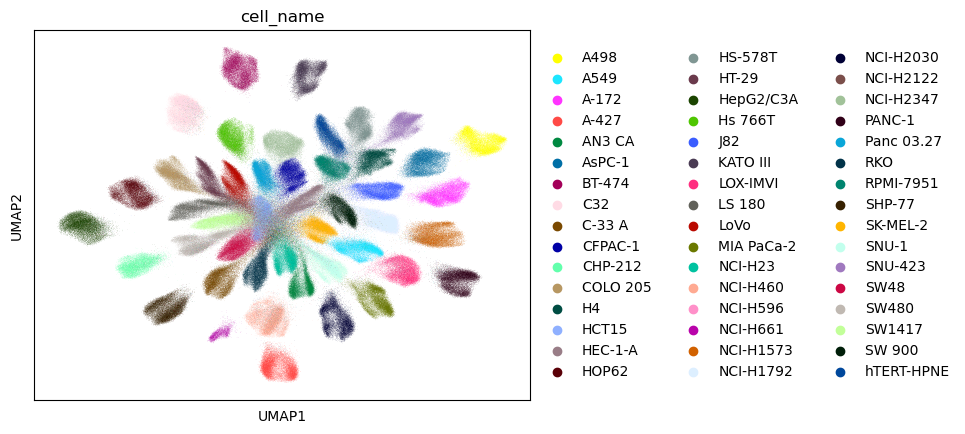

In [4]:
# plot UMAP with piSCVI embeddings
print("Computing neighbors...")
sc.pp.neighbors(adata, use_rep="X_piSCVI", n_neighbors=20)
print("Computing UMAP...")
sc.tl.umap(adata)

# Plot UMAP
print("Plotting...")
sc.pl.umap(adata, color="cell_name")

In [ ]:
X = adata.X.toarray()

In [ ]:
# Check if adata.X has raw counts data
rows = X[:1000, :]
print("Min value:", row.min())
print("Max value:", row.max())
print("Data type:", X.dtype)

# is_integer = np.all(np.equal(np.mod(X, 1), 0))
# print("Only integer values:", is_integer)

In [7]:
mask_treat = (adata.obs["cell_line"] == "CVCL_0023") & (adata.obs["Agg_Treatment"] != "DMSO_TF")
mask_control = (adata.obs["cell_line"] == "CVCL_0023") & (adata.obs["Agg_Treatment"] == "DMSO_TF")
print(f"Treated samples: {len(adata.obs[mask_treat])}")
print(f"Control samples: {len(adata.obs[mask_control])}")
print(f"Ratio: {len(adata.obs[mask_control]) / len(adata.obs[mask_treat])}")

Treated samples: 195428
Control samples: 9771
Ratio: 0.0499979532103895


In [6]:
X = adata.X

if sparse.issparse(X):
    data = X.data
    print("NaN:", np.isnan(data).any())
    print("Inf:", np.isinf(data).any())
    # print("Neg Inf:", np.isneginf(X).any())
else:
    print("NaN:", np.isnan(X).any())
    print("Inf:", np.isinf(X).any())
    # print("Neg Inf:", np.isneginf(X).any())

NaN: False
Inf: False


## GDSC Sensitivities

In [ ]:
path = "/cluster/work/bewi/data/tahoe100/metadata/controls_col_cellCode_with_sensitivity.csv"
df = pd.read_csv(path)

In [2]:
# Generate subset
path = "/cluster/work/bewi/data/tahoe100/metadata/controls_col_cellCode_with_sensitivity.csv"
df_sub = pd.read_csv(path, nrows=10_000)
df_sub.to_csv("/cluster/work/bewi/data/tahoe100/metadata/controls_col_cellCode_with_sensitivity_debug.csv")

In [3]:
df

,BARCODE_SUB_LIB_ID,cell_line,cell_name,sensitivity,drug,score
0,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Doxorubicin___133,0.012232
1,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Doxorubicin___1386,0.024131
2,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Etoposide,0.100846
3,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Gemcitabine___135,0.000717
4,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Gemcitabine___1393,0.001397
...,...,...,...,...,...,...
174439434,96_192_179-lib_2608,CVCL_1517,NCI-H2030,0.0,Dabrafenib,0.807755
174439435,96_192_179-lib_2608,CVCL_1517,NCI-H2030,0.0,Temozolomide,0.870358
174439436,96_192_179-lib_2608,CVCL_1517,NCI-H2030,0.0,Fulvestrant,0.995623
174439437,96_192_179-lib_2608,CVCL_1517,NCI-H2030,1.0,SN-38___1490,0.174052


In [5]:
def norm(x):
    return re.sub(r"[^0-9A-Za-z]", "", str(x)).upper()

df["_norm"] = df["cell_name"].map(norm)


KeyboardInterrupt



In [ ]:
matched = df[df["drug"].notna()]
print("TRUE matched cells (normalized):", matched["_norm"].nunique())

In [7]:
print("Number of samples:", df["BARCODE_SUB_LIB_ID"].nunique())
print("Number of drugs:", df["drug"].nunique())
print("Number of lines:", df["cell_line"].nunique())
print("Number of names:", df["cell_name"].nunique()) 

Number of samples: 2330149
Number of drugs: 85
Number of lines: 50
Number fo names: 68


In [9]:
df["cell_line"].unique()

array(['CVCL_0428', 'CVCL_0332', 'CVCL_1666', 'CVCL_0480', 'CVCL_1285',
       'CVCL_0131', 'CVCL_0546', 'CVCL_1381', 'CVCL_1239', 'CVCL_C466',
       'CVCL_0023', 'CVCL_1056', 'CVCL_1125', 'CVCL_1517', 'CVCL_0399',
       'CVCL_0397', 'CVCL_0099', 'CVCL_0292', 'CVCL_0334', 'CVCL_1478',
       'CVCL_0366', 'CVCL_0152', 'CVCL_0459', 'CVCL_1547', 'CVCL_1119',
       'CVCL_0320', 'CVCL_1731', 'CVCL_0218', 'CVCL_1717', 'CVCL_1098',
       'CVCL_1495', 'CVCL_0504', 'CVCL_0359', 'CVCL_1094', 'CVCL_1097',
       'CVCL_1550', 'CVCL_0371', 'CVCL_1055', 'CVCL_0293', 'CVCL_0069',
       'CVCL_0028', 'CVCL_1724', 'CVCL_1635', 'CVCL_0179', 'CVCL_1693',
       'CVCL_1715', 'CVCL_1716', 'CVCL_1577', 'CVCL_1571', 'CVCL_1531'],
      dtype=object)

In [3]:
df["drug"].unique()

array(['Doxorubicin___133', 'Doxorubicin___1386', 'Etoposide',
       'Gemcitabine___135', 'Gemcitabine___1393', 'Mitomycin-C',
       'Vinorelbine', 'Bicalutamide___150', 'Bicalutamide___1502',
       'Ponatinib', '5-Fluorouracil', 'Bexarotene', 'Bleomycin',
       'Pazopanib', 'Ruxolitinib', 'Idelalisib', 'Cabozantinib',
       'Belinostat', 'Alectinib', 'Pemetrexed', 'Panobinostat',
       'Vinblastine', 'Cisplatin___1005', 'Cisplatin___1496',
       'Cytarabine', 'Docetaxel', 'Methotrexate', 'Tretinoin',
       'Gefitinib', 'Vorinostat', 'Nilotinib', 'Temsirolimus',
       'Olaparib___1017', 'Olaparib___1495', 'Bosutinib', 'Lenalidomide',
       'Axitinib', 'Afatinib___1032', 'Afatinib___1377', 'Vismodegib',
       'Palbociclib', 'Cetuximab', 'Rucaparib', 'Trametinib',
       'Dabrafenib', 'Temozolomide', 'Fulvestrant', 'SN-38___1490',
       'SN-38___1494', 'Cisplatin', 'Docetaxel___1007',
       'Docetaxel___1819', 'Olaparib', 'Afatinib', 'Dasatinib',
       'Paclitaxel', 'Crizot

In [4]:
mask = (df["cell_line"] == "CVCL_0428") & (df["drug"] == "Vorinostat")
df[mask]

,BARCODE_SUB_LIB_ID,cell_line,cell_name,sensitivity,drug,score
29,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Vorinostat,0.433650
55,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,0.0,Vorinostat,0.676563
2573,95_006_119-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Vorinostat,0.433650
2599,95_006_119-lib_1681,CVCL_0428,MIA-PaCa-2,0.0,Vorinostat,0.676563
2930,95_006_180-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Vorinostat,0.433650
...,...,...,...,...,...,...
174433956,96_165_021-lib_2608,CVCL_0428,MIA PaCa-2,0.0,Vorinostat,0.676563
174434197,96_166_173-lib_2608,CVCL_0428,MIA PaCa-2,1.0,Vorinostat,0.433650
174434223,96_166_173-lib_2608,CVCL_0428,MIA PaCa-2,0.0,Vorinostat,0.676563
174437344,96_184_109-lib_2608,CVCL_0428,MIA PaCa-2,1.0,Vorinostat,0.433650


In [12]:
print("Trametinib" in df["drug"].unique())

True


In [15]:
mask = df["BARCODE_SUB_LIB_ID"] == "95_001_015-lib_1681"
df[mask]

,BARCODE_SUB_LIB_ID,cell_line,cell_name,sensitivity,drug,score
0,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Doxorubicin___133,0.012232
1,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Doxorubicin___1386,0.024131
2,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Etoposide,0.100846
3,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Gemcitabine___135,0.000717
4,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Gemcitabine___1393,0.001397
...,...,...,...,...,...,...
90,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,0.0,Nelarabine,0.918049
91,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,0.0,Vincristine,0.790108
92,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,0.0,Venetoclax,0.796557
93,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,0.0,Osimertinib,0.954948


In [ ]:
print("Varying sensitivity samples for:")

counter = 1
for line in df["cell_line"].unique():
    for drug in df["drug"].unique():
        print(counter)
        counter += 1
        mask = (df["cell_line"] == line) & (df["drug"] == drug)
        if df[mask]["sensitivity"].nunique() > 1:
            print(f"{line} - {drug}")

Varying sensitivity samples for:
1
2
3


## Tahoe /GDSC Controls

In [3]:
# controls_path = "/cluster/work/bewi/data/tahoe100/h5ad/controls_merged.h5ad"
# controls_path = "/cluster/work/bewi/data/tahoe100/h5ad/controls_merged_hvg_log1p.h5ad"
controls_path = "/cluster/scratch/rquiles/GDSC_control_counts.h5ad"
# controls = sc.read_h5ad(controls_path, backed = "r")
controls = sc.read_h5ad(controls_path)

In [22]:
all_controls_path = "/cluster/work/bewi/data/tahoe100/h5ad/controls_merged.h5ad"
all_controls = sc.read_h5ad(all_controls_path)

In [7]:
# Metadata file for Zeroshot
metadata_path = "/cluster/work/bewi/data/tahoe100/metadata/controls_col_cellCode_with_sensitivity.csv"
df = pd.read_csv(metadata_path)

In [9]:
df.head()

,BARCODE_SUB_LIB_ID,cell_line,cell_name,sensitivity,drug,score
0,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Doxorubicin___133,0.012232
1,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Doxorubicin___1386,0.024131
2,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Etoposide,0.100846
3,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Gemcitabine___135,0.000717
4,95_001_015-lib_1681,CVCL_0428,MIA-PaCa-2,1.0,Gemcitabine___1393,0.001397


In [24]:
all_controls

AnnData object with n_obs × n_vars = 2330156 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'source_plate'

In [25]:
controls

AnnData object with n_obs × n_vars = 2321181 × 5000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'Agg_Treatment', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'split', 'control', 'dose'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'fields', 'hvg'

In [6]:
controls.var["highly_variable"].sum()

5000

In [28]:
all_controls.obs.loc['95_052_170-lib_1681']

sample                               smp_2453
gene_count                                494
tscp_count                                681
mread_count                               794
drugname_drugconc    [('DMSO_TF', 0.0, 'uM')]
drug                                  DMSO_TF
cell_line                           CVCL_1715
sublibrary                           lib_1681
BARCODE                            95_052_170
pcnt_mito                            0.151248
S_score                             -0.244019
G2M_score                           -0.223626
phase                                      G1
pass_filter                           minimal
cell_name                             SW 1088
plate                                 plate10
source_plate                          plate10
Name: 95_052_170-lib_1681, dtype: object

In [93]:
# Make sure all sample_ids are contained
idx = df["BARCODE_SUB_LIB_ID"].unique()
# controls.obs.loc[idx]
# print("All sample_ids included!")

# Get the cell_names of included cell_lines
all_controls_subset = all_controls.obs.loc[idx]

All sample_ids included!


In [95]:
print(f"Number of cell lines in tahoe: {all_controls.obs['cell_name'].nunique()}")
print(f"Number of cell lines in GDSC matching: {all_controls_subset['cell_name'].nunique()}")
print(f"Represented cell lines: {sorted(all_controls_subset['cell_name'].unique().tolist())}")

Number of cell lines in tahoe: 50
Number of cell lines in GDSC matching: 50
Represented cell lines: ['A-172', 'A-427', 'A498', 'A549', 'AN3 CA', 'AsPC-1', 'BT-474', 'C-33 A', 'C32', 'CFPAC-1', 'CHP-212', 'COLO 205', 'H4', 'HCT15', 'HEC-1-A', 'HOP62', 'HS-578T', 'HT-29', 'HepG2/C3A', 'Hs 766T', 'J82', 'KATO III', 'LOX-IMVI', 'LS 180', 'LoVo', 'MIA PaCa-2', 'NCI-H1573', 'NCI-H1792', 'NCI-H2030', 'NCI-H2122', 'NCI-H23', 'NCI-H2347', 'NCI-H460', 'NCI-H596', 'NCI-H661', 'PANC-1', 'Panc 03.27', 'RKO', 'RPMI-7951', 'SHP-77', 'SK-MEL-2', 'SNU-1', 'SNU-423', 'SW 1088', 'SW 1271', 'SW 900', 'SW1417', 'SW48', 'SW480', 'hTERT-HPNE']


## Merge AnnDatas

In [10]:
import anndata as ad
adata1 = sc.read("/cluster/scratch/rquiles/GDSC_treated_1.h5ad")
adata2 = sc.read("/cluster/scratch/rquiles/GDSC_treated_2.h5ad")

In [21]:
# Ensure var_names match
assert set(adata1.var_names) == set(adata2.var_names), "Gene sets differ!"

AssertionError: Gene sets differ!

In [23]:
# 1. Find shared genes
shared_genes = np.intersect1d(adata1.var_names, adata2.var_names)

print(f"Shared genes: {len(shared_genes)}")

# 2. Subset both objects to shared genes (in SAME ORDER)
adata1_sub = adata1[:, shared_genes].copy()
adata2_sub = adata2[:, shared_genes].copy()

# 3. Make sure gene order is identical
adata2_sub = adata2_sub[:, adata1_sub.var_names].copy()

# 4. Merge using inner join (safe)
adata_merged = ad.concat([adata1_sub, adata2_sub], join="inner")

print(adata_merged)

Shared genes: 2109
AnnData object with n_obs × n_vars = 11476876 × 2109
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'Agg_Treatment', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'split', 'control', 'dose'


In [24]:
adata_merged.write("/cluster/scratch/rquiles/gdsc/treated/GDSC_treated.h5ad")

In [26]:
adata_merged.obs["cell_name"].nunique()

46

## Get controls from GDSC treated

In [29]:
adata = sc.read_h5ad("/cluster/scratch/rquiles/gdsc/treated/GDSC_treated.h5ad")

In [34]:
control_idx = adata.obs[adata.obs["Agg_Treatment"] == "DMSO_TF"].index
adata_control = adata[control_idx].copy()

In [40]:
adata_control

AnnData object with n_obs × n_vars = 1912381 × 2109
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'Agg_Treatment', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'split', 'control', 'dose'

In [37]:
adata_control.write("/cluster/scratch/rquiles/gdsc/controls/transformed_controls.h5ad") # now controls_log1p.h5ad

In [38]:
# Now generate corresponding counts dataset
adata_counts = sc.read_h5ad("/cluster/work/bewi/data/tahoe100/h5ad/controls_merged.h5ad")

In [42]:
adata_counts_control = adata_counts[control_idx].copy()

In [43]:
adata_counts_control

AnnData object with n_obs × n_vars = 1912381 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'source_plate'

In [44]:
adata_counts_control.write("/cluster/scratch/rquiles/gdsc/controls/controls.h5ad")

## Subset Controls to GDSC

In [2]:
# Unprocessed controls
path_controls = "/cluster/work/bewi/data/tahoe100/h5ad/controls_merged.h5ad"
path_gdsc = "/cluster/scratch/rquiles/gdsc/controls/controls_log1p.h5ad"
export_path = "/cluster/work/bewi/data/tahoe100/h5ad/gdsc_controls_merged.h5ad"

In [8]:
# Processed controls
path_controls = "/cluster/work/bewi/data/tahoe100/h5ad/controls_processed.h5ad"
path_gdsc = "/cluster/scratch/rquiles/gdsc/controls/controls_log1p.h5ad"
export_path = "/cluster/work/bewi/data/tahoe100/h5ad/gdsc_controls_processed.h5ad"

In [9]:
tahoe_controls = sc.read_h5ad(path_controls)
gdsc_controls = sc.read_h5ad(path_gdsc)

In [10]:
sample_ids = gdsc_controls.obs_names
final_adata = tahoe_controls[sample_ids].copy()

In [11]:
tahoe_controls

AnnData object with n_obs × n_vars = 2330156 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'source_plate'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca', 'X_piSCVI'
    varm: 'PCs'

In [12]:
final_adata

AnnData object with n_obs × n_vars = 1912381 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'source_plate'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca', 'X_piSCVI'
    varm: 'PCs'

In [13]:
final_adata.write(export_path)